<a href="https://colab.research.google.com/github/Srinivaskolli45/s5_assignment/blob/main/s5_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#assignment 5 for BN,GN and LN 

from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms    


In [2]:
!git clone https://github.com/Srinivaskolli45/s5_assignment.git



Cloning into 's5_assignment'...
remote: Enumerating objects: 18, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 18 (delta 5), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (18/18), 72.94 KiB | 1.55 MiB/s, done.


In [3]:
import sys
sys.path.append('/content/s5_assignment/')

from model import *

In [5]:
import torchvision

use_cuda = torch.cuda.is_available()
print("CUDA Available?", use_cuda)
torch.manual_seed(1)
batch_size = 128

#kwargs = {'num_workers': 4, 'pin_memory': True} if use_cuda else {}
kwargs = dict(num_workers= 4, pin_memory= True if use_cuda else False,shuffle=True,batch_size=batch_size)

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,)),
                        transforms.RandomRotation(degrees=7)
                    ])),**kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                        #transforms.RandomRotation(degrees=7)
                    ])),**kwargs)

     


CUDA Available? True


In [6]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net(norm_type="nn.BatchNorm2d").to(device)
#model = Net(norm_type="nn.GroupNorm").to(device)
#model = Net(norm_type="nn.LayerNorm").to(device)
summary(model, input_size=(1, 28, 28))



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]             100
       BatchNorm2d-2           [-1, 10, 26, 26]              20
              ReLU-3           [-1, 10, 26, 26]               0
            Conv2d-4           [-1, 10, 24, 24]             910
       BatchNorm2d-5           [-1, 10, 24, 24]              20
              ReLU-6           [-1, 10, 24, 24]               0
         MaxPool2d-7           [-1, 10, 12, 12]               0
            Conv2d-8           [-1, 32, 10, 10]           2,912
       BatchNorm2d-9           [-1, 32, 10, 10]              64
             ReLU-10           [-1, 32, 10, 10]               0
           Conv2d-11             [-1, 10, 8, 8]           2,890
      BatchNorm2d-12             [-1, 10, 8, 8]              20

/content/s5_assignment/model.py:141: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


In [7]:
from tqdm import tqdm
def train(model, device, train_loader, optimizer, epoch):
    train_loss = 0
    correct = 0
    processed=0
    model.train()
    pbar = tqdm(train_loader)
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        train_loss +=loss
        pred = output.argmax(dim=1,keepdim=True)
        
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)
        pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx} Accurary={100*correct/processed:0.2f}')

    
   # print('\nTrain set: average loss: {:.4f}, accuracy: {}/{} ({:.0f}%)\n'.format(
   
def test(model, device, test_loader,test_losses=[],test_acc=[]):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)
    return test_losses,test_acc

In [8]:
#group normalization
from torch.optim.lr_scheduler import StepLR
model = Net(norm_type="nn.GroupNorm").to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
test_loss_gn=[]
test_acc_gn=[]
EPOCHS =20
#schedular = StepLR(optimizer=optimizer,step_size=6,gamma=0.1)
for epoch in range(EPOCHS):
    print(f'Epoch--> {epoch+1}')
    train(model, device, train_loader, optimizer, epoch)
    #print("Current learning rate:", optimizer.param_groups[0]['lr'])
    #schedular.step()
    test_loss_gn ,test_acc_gn =test(model, device, test_loader,test_loss_gn ,test_acc_gn)

Epoch--> 1


loss=0.35300275683403015 batch_id=468 Accurary=77.44: 100%|██████████| 469/469 [00:37<00:00, 12.65it/s]



Test set: Average loss: 0.3226, Accuracy: 9633/10000 (96.33%)

Epoch--> 2


loss=0.23876620829105377 batch_id=468 Accurary=95.95: 100%|██████████| 469/469 [00:35<00:00, 13.27it/s]



Test set: Average loss: 0.1587, Accuracy: 9731/10000 (97.31%)

Epoch--> 3


loss=0.09748660773038864 batch_id=468 Accurary=97.37: 100%|██████████| 469/469 [00:35<00:00, 13.10it/s]



Test set: Average loss: 0.1078, Accuracy: 9817/10000 (98.17%)

Epoch--> 4


loss=0.12116650491952896 batch_id=468 Accurary=97.78: 100%|██████████| 469/469 [00:34<00:00, 13.54it/s]



Test set: Average loss: 0.0870, Accuracy: 9814/10000 (98.14%)

Epoch--> 5


loss=0.07765460014343262 batch_id=468 Accurary=98.05: 100%|██████████| 469/469 [00:34<00:00, 13.49it/s]



Test set: Average loss: 0.0702, Accuracy: 9849/10000 (98.49%)

Epoch--> 6


loss=0.21104228496551514 batch_id=468 Accurary=98.27: 100%|██████████| 469/469 [00:35<00:00, 13.12it/s]



Test set: Average loss: 0.0548, Accuracy: 9891/10000 (98.91%)

Epoch--> 7


loss=0.09523472934961319 batch_id=468 Accurary=98.36: 100%|██████████| 469/469 [00:36<00:00, 13.03it/s]



Test set: Average loss: 0.0515, Accuracy: 9895/10000 (98.95%)

Epoch--> 8


loss=0.03862379118800163 batch_id=468 Accurary=98.58: 100%|██████████| 469/469 [00:35<00:00, 13.04it/s]



Test set: Average loss: 0.0498, Accuracy: 9894/10000 (98.94%)

Epoch--> 9


loss=0.0928008034825325 batch_id=468 Accurary=98.52: 100%|██████████| 469/469 [00:36<00:00, 12.95it/s]



Test set: Average loss: 0.0460, Accuracy: 9899/10000 (98.99%)

Epoch--> 10


loss=0.07692943513393402 batch_id=468 Accurary=98.69: 100%|██████████| 469/469 [00:36<00:00, 12.93it/s]



Test set: Average loss: 0.0471, Accuracy: 9888/10000 (98.88%)

Epoch--> 11


loss=0.02534942328929901 batch_id=468 Accurary=98.81: 100%|██████████| 469/469 [00:35<00:00, 13.07it/s]



Test set: Average loss: 0.0515, Accuracy: 9869/10000 (98.69%)

Epoch--> 12


loss=0.06647059321403503 batch_id=468 Accurary=98.86: 100%|██████████| 469/469 [00:36<00:00, 12.97it/s]



Test set: Average loss: 0.0398, Accuracy: 9912/10000 (99.12%)

Epoch--> 13


loss=0.03493000194430351 batch_id=468 Accurary=98.90: 100%|██████████| 469/469 [00:36<00:00, 13.02it/s]



Test set: Average loss: 0.0408, Accuracy: 9892/10000 (98.92%)

Epoch--> 14


loss=0.13668352365493774 batch_id=468 Accurary=98.93: 100%|██████████| 469/469 [00:35<00:00, 13.10it/s]



Test set: Average loss: 0.0437, Accuracy: 9899/10000 (98.99%)

Epoch--> 15


loss=0.07172077149152756 batch_id=468 Accurary=98.88: 100%|██████████| 469/469 [00:35<00:00, 13.31it/s]



Test set: Average loss: 0.0397, Accuracy: 9905/10000 (99.05%)

Epoch--> 16


loss=0.032426513731479645 batch_id=468 Accurary=98.92: 100%|██████████| 469/469 [00:35<00:00, 13.28it/s]



Test set: Average loss: 0.0406, Accuracy: 9900/10000 (99.00%)

Epoch--> 17


loss=0.03795948997139931 batch_id=468 Accurary=98.97: 100%|██████████| 469/469 [00:34<00:00, 13.46it/s]



Test set: Average loss: 0.0465, Accuracy: 9871/10000 (98.71%)

Epoch--> 18


loss=0.050601691007614136 batch_id=468 Accurary=99.02: 100%|██████████| 469/469 [00:35<00:00, 13.08it/s]



Test set: Average loss: 0.0508, Accuracy: 9853/10000 (98.53%)

Epoch--> 19


loss=0.03630935400724411 batch_id=468 Accurary=99.03: 100%|██████████| 469/469 [00:35<00:00, 13.05it/s]



Test set: Average loss: 0.0377, Accuracy: 9908/10000 (99.08%)

Epoch--> 20


loss=0.03172536566853523 batch_id=468 Accurary=99.08: 100%|██████████| 469/469 [00:36<00:00, 12.74it/s]



Test set: Average loss: 0.0347, Accuracy: 9910/10000 (99.10%)



In [9]:
#Layer normalization
from torch.optim.lr_scheduler import StepLR
model = Net(norm_type="nn.LayerNorm").to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
test_loss_ln=[]
test_acc_ln=[]
EPOCHS =20
#schedular = StepLR(optimizer=optimizer,step_size=6,gamma=0.1)
for epoch in range(EPOCHS):
    print(f'Epoch--> {epoch+1}')
    train(model, device, train_loader, optimizer, epoch)
    #print("Current learning rate:", optimizer.param_groups[0]['lr'])
    #schedular.step()
    test_loss_ln ,test_acc_ln =test(model, device, test_loader,test_loss_ln ,test_acc_ln)

Epoch--> 1


loss=2.1975812911987305 batch_id=468 Accurary=27.16: 100%|██████████| 469/469 [00:38<00:00, 12.19it/s]



Test set: Average loss: 2.1924, Accuracy: 3328/10000 (33.28%)

Epoch--> 2


loss=2.0842511653900146 batch_id=468 Accurary=42.15: 100%|██████████| 469/469 [00:36<00:00, 12.97it/s]



Test set: Average loss: 2.0607, Accuracy: 5842/10000 (58.42%)

Epoch--> 3


loss=1.9037977457046509 batch_id=468 Accurary=66.09: 100%|██████████| 469/469 [00:35<00:00, 13.05it/s]



Test set: Average loss: 1.8780, Accuracy: 7491/10000 (74.91%)

Epoch--> 4


loss=1.684882640838623 batch_id=468 Accurary=75.18: 100%|██████████| 469/469 [00:36<00:00, 12.88it/s]



Test set: Average loss: 1.6430, Accuracy: 8017/10000 (80.17%)

Epoch--> 5


loss=1.4581371545791626 batch_id=468 Accurary=80.72: 100%|██████████| 469/469 [00:36<00:00, 12.79it/s]



Test set: Average loss: 1.4141, Accuracy: 8347/10000 (83.47%)

Epoch--> 6


loss=1.1641039848327637 batch_id=468 Accurary=83.77: 100%|██████████| 469/469 [00:36<00:00, 12.84it/s]



Test set: Average loss: 1.2013, Accuracy: 8504/10000 (85.04%)

Epoch--> 7


loss=1.0433454513549805 batch_id=468 Accurary=84.44: 100%|██████████| 469/469 [00:36<00:00, 12.98it/s]



Test set: Average loss: 1.0204, Accuracy: 8516/10000 (85.16%)

Epoch--> 8


loss=0.9679727554321289 batch_id=468 Accurary=84.69: 100%|██████████| 469/469 [00:34<00:00, 13.55it/s]



Test set: Average loss: 0.9345, Accuracy: 8467/10000 (84.67%)

Epoch--> 9


loss=0.7487780451774597 batch_id=468 Accurary=85.42: 100%|██████████| 469/469 [00:35<00:00, 13.37it/s]



Test set: Average loss: 0.7539, Accuracy: 8720/10000 (87.20%)

Epoch--> 10


loss=0.6651621460914612 batch_id=468 Accurary=85.92: 100%|██████████| 469/469 [00:35<00:00, 13.36it/s]



Test set: Average loss: 0.6688, Accuracy: 8752/10000 (87.52%)

Epoch--> 11


loss=0.5818418860435486 batch_id=468 Accurary=86.81: 100%|██████████| 469/469 [00:35<00:00, 13.17it/s]



Test set: Average loss: 0.6062, Accuracy: 8784/10000 (87.84%)

Epoch--> 12


loss=0.604956328868866 batch_id=468 Accurary=87.53: 100%|██████████| 469/469 [00:36<00:00, 12.85it/s]



Test set: Average loss: 0.5383, Accuracy: 9281/10000 (92.81%)

Epoch--> 13


loss=0.45461252331733704 batch_id=468 Accurary=94.32: 100%|██████████| 469/469 [00:36<00:00, 12.89it/s]



Test set: Average loss: 0.4398, Accuracy: 9633/10000 (96.33%)

Epoch--> 14


loss=0.4573972225189209 batch_id=468 Accurary=95.32: 100%|██████████| 469/469 [00:36<00:00, 12.97it/s]



Test set: Average loss: 0.3952, Accuracy: 9635/10000 (96.35%)

Epoch--> 15


loss=0.4026391804218292 batch_id=468 Accurary=95.72: 100%|██████████| 469/469 [00:36<00:00, 12.93it/s]



Test set: Average loss: 0.3705, Accuracy: 9595/10000 (95.95%)

Epoch--> 16


loss=0.3274747133255005 batch_id=468 Accurary=96.18: 100%|██████████| 469/469 [00:36<00:00, 12.93it/s]



Test set: Average loss: 0.3325, Accuracy: 9665/10000 (96.65%)

Epoch--> 17


loss=0.32760486006736755 batch_id=468 Accurary=96.27: 100%|██████████| 469/469 [00:36<00:00, 12.98it/s]



Test set: Average loss: 0.3195, Accuracy: 9661/10000 (96.61%)

Epoch--> 18


loss=0.2926596403121948 batch_id=468 Accurary=96.59: 100%|██████████| 469/469 [00:36<00:00, 12.91it/s]



Test set: Average loss: 0.2714, Accuracy: 9699/10000 (96.99%)

Epoch--> 19


loss=0.256576806306839 batch_id=468 Accurary=96.77: 100%|██████████| 469/469 [00:35<00:00, 13.05it/s]



Test set: Average loss: 0.2611, Accuracy: 9728/10000 (97.28%)

Epoch--> 20


loss=0.33669352531433105 batch_id=468 Accurary=96.86: 100%|██████████| 469/469 [00:35<00:00, 13.21it/s]



Test set: Average loss: 0.2483, Accuracy: 9748/10000 (97.48%)



In [10]:
#Batch normalization
from torch.optim.lr_scheduler import StepLR
model = Net(norm_type="nn.BatchNorm2d").to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
test_loss_bn=[]
test_acc_bn=[]
EPOCHS =20
#schedular = StepLR(optimizer=optimizer,step_size=6,gamma=0.1)
for epoch in range(EPOCHS):
    print(f'Epoch--> {epoch+1}')
    train(model, device, train_loader, optimizer, epoch)
    #print("Current learning rate:", optimizer.param_groups[0]['lr'])
    #schedular.step()
    test_loss_bn ,test_acc_bn =test(model, device, test_loader,test_loss_bn ,test_acc_bn)

Epoch--> 1


loss=0.16995172202587128 batch_id=468 Accurary=89.57: 100%|██████████| 469/469 [00:35<00:00, 13.17it/s]



Test set: Average loss: 0.2078, Accuracy: 9569/10000 (95.69%)

Epoch--> 2


loss=0.07800362259149551 batch_id=468 Accurary=97.39: 100%|██████████| 469/469 [00:35<00:00, 13.19it/s]



Test set: Average loss: 0.1436, Accuracy: 9629/10000 (96.29%)

Epoch--> 3


loss=0.05109599232673645 batch_id=468 Accurary=97.99: 100%|██████████| 469/469 [00:35<00:00, 13.33it/s]



Test set: Average loss: 0.0674, Accuracy: 9848/10000 (98.48%)

Epoch--> 4


loss=0.0701422467827797 batch_id=468 Accurary=98.22: 100%|██████████| 469/469 [00:34<00:00, 13.41it/s]



Test set: Average loss: 0.0587, Accuracy: 9873/10000 (98.73%)

Epoch--> 5


loss=0.03936217725276947 batch_id=468 Accurary=98.36: 100%|██████████| 469/469 [00:35<00:00, 13.17it/s]



Test set: Average loss: 0.0593, Accuracy: 9856/10000 (98.56%)

Epoch--> 6


loss=0.14313936233520508 batch_id=468 Accurary=98.49: 100%|██████████| 469/469 [00:36<00:00, 12.98it/s]



Test set: Average loss: 0.0463, Accuracy: 9887/10000 (98.87%)

Epoch--> 7


loss=0.06637401133775711 batch_id=468 Accurary=98.62: 100%|██████████| 469/469 [00:36<00:00, 12.89it/s]



Test set: Average loss: 0.0528, Accuracy: 9864/10000 (98.64%)

Epoch--> 8


loss=0.0580604262650013 batch_id=468 Accurary=98.68: 100%|██████████| 469/469 [00:35<00:00, 13.05it/s]



Test set: Average loss: 0.0414, Accuracy: 9894/10000 (98.94%)

Epoch--> 9


loss=0.020176682621240616 batch_id=468 Accurary=98.82: 100%|██████████| 469/469 [00:36<00:00, 12.99it/s]



Test set: Average loss: 0.0389, Accuracy: 9898/10000 (98.98%)

Epoch--> 10


loss=0.0283524002879858 batch_id=468 Accurary=98.83: 100%|██████████| 469/469 [00:35<00:00, 13.07it/s]



Test set: Average loss: 0.0413, Accuracy: 9891/10000 (98.91%)

Epoch--> 11


loss=0.025368453934788704 batch_id=468 Accurary=98.91: 100%|██████████| 469/469 [00:35<00:00, 13.12it/s]



Test set: Average loss: 0.0320, Accuracy: 9916/10000 (99.16%)

Epoch--> 12


loss=0.04348894953727722 batch_id=468 Accurary=98.90: 100%|██████████| 469/469 [00:35<00:00, 13.06it/s]



Test set: Average loss: 0.0346, Accuracy: 9899/10000 (98.99%)

Epoch--> 13


loss=0.04331304505467415 batch_id=468 Accurary=98.94: 100%|██████████| 469/469 [00:35<00:00, 13.39it/s]



Test set: Average loss: 0.0336, Accuracy: 9913/10000 (99.13%)

Epoch--> 14


loss=0.022968875244259834 batch_id=468 Accurary=98.97: 100%|██████████| 469/469 [00:34<00:00, 13.56it/s]



Test set: Average loss: 0.0345, Accuracy: 9901/10000 (99.01%)

Epoch--> 15


loss=0.018635379150509834 batch_id=468 Accurary=98.97: 100%|██████████| 469/469 [00:34<00:00, 13.51it/s]



Test set: Average loss: 0.0321, Accuracy: 9916/10000 (99.16%)

Epoch--> 16


loss=0.015214928425848484 batch_id=468 Accurary=99.03: 100%|██████████| 469/469 [00:35<00:00, 13.23it/s]



Test set: Average loss: 0.0323, Accuracy: 9902/10000 (99.02%)

Epoch--> 17


loss=0.015572377480566502 batch_id=468 Accurary=99.03: 100%|██████████| 469/469 [00:35<00:00, 13.18it/s]



Test set: Average loss: 0.0338, Accuracy: 9910/10000 (99.10%)

Epoch--> 18


loss=0.04172472283244133 batch_id=468 Accurary=99.14: 100%|██████████| 469/469 [00:35<00:00, 13.07it/s]



Test set: Average loss: 0.0374, Accuracy: 9892/10000 (98.92%)

Epoch--> 19


loss=0.025219814851880074 batch_id=468 Accurary=99.13: 100%|██████████| 469/469 [00:35<00:00, 13.27it/s]



Test set: Average loss: 0.0272, Accuracy: 9929/10000 (99.29%)

Epoch--> 20


loss=0.038935497403144836 batch_id=468 Accurary=99.12: 100%|██████████| 469/469 [00:35<00:00, 13.12it/s]



Test set: Average loss: 0.0309, Accuracy: 9910/10000 (99.10%)



Text(0.5, 1.0, 'Test Accuracy')

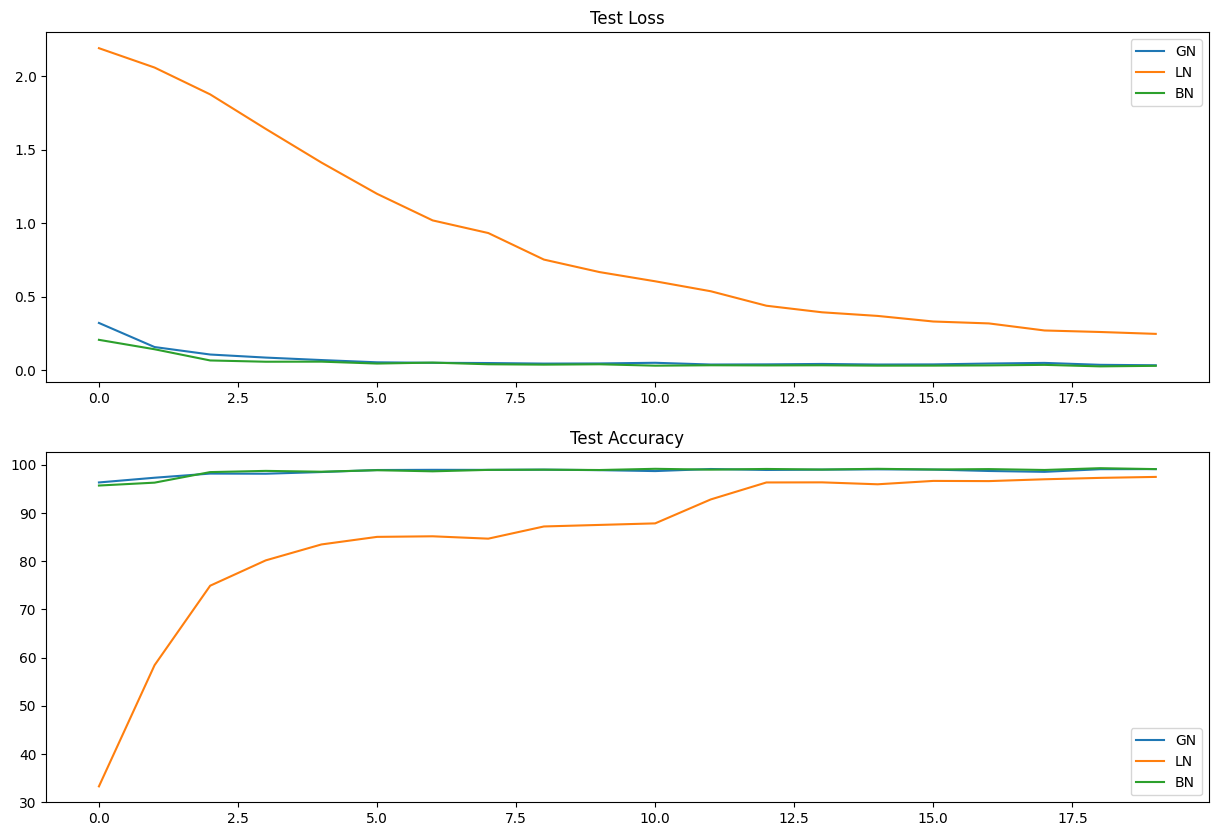

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,1,figsize=(15,10))

test_loss_gn = torch.tensor(test_loss_gn, device = 'cpu')
test_loss_ln = torch.tensor(test_loss_ln, device = 'cpu')
test_losses_bn = torch.tensor(test_loss_bn, device = 'cpu')

axs[0].plot(test_loss_gn,label ='GN')
axs[0].plot(test_loss_ln,label ='LN')
axs[0].plot(test_loss_bn,label ='BN')
axs[0].legend()
axs[0].set_title("Test Loss")


axs[1].plot(test_acc_gn,label ='GN')
axs[1].plot(test_acc_ln,label ='LN')
axs[1].plot(test_acc_bn,label ='BN')
axs[1].legend()
axs[1].set_title("Test Accuracy")